In [1]:
using PyPlot
using Distributions
using LinearAlgebra
using Flux;

┌ Warning: `haskey(::TargetIterator, name::String)` is deprecated, use `Target(; name = name) !== nothing` instead.
│   caller = llvm_compat(::VersionNumber) at compatibility.jl:176
└ @ CUDAnative C:\Users\jbere\.julia\packages\CUDAnative\ierw8\src\compatibility.jl:176


In [2]:
#Hyperparameters
n = 10
N = 40
σₐ = 0.001
k_range = 6
k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] #November 3
k_list_lite = [i for i in 1:k_range];

In [3]:
#Functions
function plot_data(data,classes,alpha=1.0)
    markers = ["o","*"]
    colors = ["blue","green"]
    for i=1:2
        mask = [classes[j] == i for j in 1:length(classes)]
        scatter(data[:,1][mask],data[:,2][mask],c=colors[i],alpha=alpha,marker=markers[i],zorder=3)
    end
end;

function unpack(Θ,k)
    m = length(Θ)
    h = 2*k
    Wₕ = reshape(Θ[1:h], k, 2);   
    bₕ = reshape(Θ[h+1:h+k], k)
    #bₕ = reshape(zeros(k), k)
    
    Wₒ = reshape(Θ[h+k+1:m-1], 1, k);
    bₒ = Θ[m]
    #bₒ = 0.0
      
    return Wₕ, bₕ, Wₒ, bₒ
end

function data_labeller(y::Array{Float64})
    labels = [y[i] > 0.5 ? 2 : 1 for i=1:length(y)]
    return labels
end

mₖ(k) = k*4 + 1;

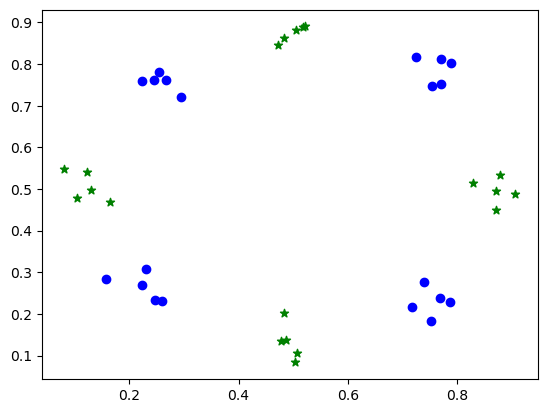

In [9]:
#Scale up - Fixed Separable Data - Multi-XOR Data
function real_data(N::Int, modes::Int, σ::Float64)
    μ₁ = [0.25, 0.25]
    μ₂ = [0.5, 0.125]
    μ₃ = [0.25, 0.75]
    μ₄ = [0.125, 0.50]
    μ₅ = [0.75, 0.75]
    μ₆ = [0.50, 0.875]
    μ₇ = [0.75, 0.25]
    μ₈ = [0.875, 0.50]
    μ = [μ₁, μ₂, μ₃, μ₄, μ₅, μ₆, μ₇, μ₈]
    Σ = [[σ, 0] [0, σ]]
    
    all_samples = zeros(Float64, (N*modes, 2))
    classes = zeros(Int, (N*modes))
    
    for i = 1:modes
        dist = MvNormal(μ[i], Σ)
        sample = rand(dist, N)::Matrix
        #scatter(sample[1,:],sample[2,:])
        all_samples[(i-1)*N+1:i*N,:] = transpose(sample)
        classes[(i-1)*N+1:i*N] = fill(i, N)
        classes = float(classes)
    end
    return all_samples, classes
end
    
data_raw, classes = real_data(Int(N/8), 8, σₐ);
classes = [(i+1) % 2 + 1 for i in classes]
y = classes

plot_data(data_raw,classes)
data = transpose(data_raw)
x = data
x_raw = data_raw
size(data);

In [85]:
#Neural Nets with Different k
model1 = Chain(
  Dense(2, 1, relu),
  Dense(1, 1, σ))

model2 = Chain(
  Dense(2, 2, relu),
  Dense(2, 1, σ))

model3 = Chain(
  Dense(2, 3, relu),
  Dense(3, 1, σ))

model4 = Chain(
  Dense(2, 4, relu),
  Dense(4, 1, σ))

Chain(Dense(2, 4, relu), Dense(4, 1, σ))

In [90]:
function accuracy(x,y)
    labels = [x[i] > 0.5 ? 2.0 : 1.0 for i in 1:length(x)]
    scores = [labels[i] == y[i] for i in 1:length(x)]
    return sum(scores)/length(x)
end

function test_net(x,y,m)    
    loss(x, y) = Flux.binarycrossentropy(m(x), y)
    ps = Flux.params(m)
    opt = Descent(0.1)
    data = [(x, y)]
    for i=1:10
        Flux.train!(loss, ps, data, opt)
        if i%10 == 0
            println(loss(x,y))
            println(accuracy(m(x),y))
        end
    end
end

test_net(x,y,model1)
test_net(x,y,model2)
test_net(x,y,model3)
test_net(x,y,model4)

MethodError: MethodError: no method matching eps(::Array{Float32,2})
Closest candidates are:
  eps(!Matched::Dates.Time) at D:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.4\Dates\src\types.jl:387
  eps(!Matched::Dates.Date) at D:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.4\Dates\src\types.jl:386
  eps(!Matched::Dates.DateTime) at D:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.4\Dates\src\types.jl:385
  ...

In [76]:
Flux.logitbinarycrossentropy(y,y)


MethodError: MethodError: no method matching -(::Int64, ::Array{Float64,1})
Closest candidates are:
  -(!Matched::PyCall.PyObject, ::Any) at C:\Users\jbere\.julia\packages\PyCall\BcTLp\src\pyoperators.jl:13
  -(::Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8}) at int.jl:51
  -(::T, !Matched::T) where T<:Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8} at int.jl:52
  ...